In [129]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas.io.data as web

%matplotlib inline

In [172]:
# step 1: Range Selection
st = dt.datetime(2000,12,1)
en = dt.datetime(2016,1,1)
sp500_tickers_lil = ['AA','AAPL','ABC','ABT','ADBE','ADI','ADM','ADP','ADSK','AEE']
sp500_tickers_joey = ['AA','AAPL','ABC','ABT','ADBE','ADI','ADM','ADP','ADSK','AEE','AEP','AES','AET','AFL','AGN','AIG','AIV','AIZ','AKAM','ALL','AMAT','AMGN','AMP','AMT','AMZN','AN','ANTM','AON','APA','APC','APD','AVB','AVY','AXP','AZO','BA','BAC','BAX','BBBY','BBT','BBY','BCR','BDX','BEN','BFB','BHI','BIIB','BK','BLL','BMY','BRCM','BSX','BXP','C','CA','CAG','CAH','CAT','CB','CBG','CBS','CCE','CCL','CELG','CHK','CHRW','CI','CINF','CL','CLX','CMA','CMCSA','CME','CMI','CMS','CNP','CNX','COF','COH','COL','COP','COST','CPB','CSCO','CSX','CTAS','CTL','CTSH','CTXS','CVS','CVX','D','DD','DE','DFS','DGX','DHI','DHR','DIS','DOV','DOW','DRI','DTE','DUK','DVN','EA','EBAY','ECL','ED','EFX','EIX','EL','EMC','EMN','EMR','EOG','EQR','ESRX','ETFC','ETN','ETR','EXC','EXPD','EXPE','F','FCX','FDX','FE','FIS','FISV','FITB','FLR','FOXA','FTR','GAS','GD','GE','GILD','GIS','GLW','GME','GOOGL','GPC','GPS','GS','GT','GWW','HAL','HAR','HAS','HBAN','HD','HES','HIG','HOG','HON','HOT','HPQ','HRB','HST','HSY','HUM','IBM','ICE','IFF','INTC','INTU','IP','IPG','ITW','JCI','JEC','JNJ','JNPR','JPM','JWN','K','KEY','KIM','KLAC','KMB','KO','KR','KSS','L','LB','LEG','LEN','LH','LLL','LLTC','LLY','LM','LMT','LNC','LOW','LUK','LUV','M','MAR','MAS','MAT','MCD','MCHP','MCK','MCO','MDLZ','MDT','MET','MHFI','MKC','MMC','MMM','MO','MON','MRK','MRO','MS','MSFT','MSI','MTB','MU','MUR','MYL','NBL','NEE','NEM','NI','NKE','NOC','NOV','NSC','NTAP','NTRS','NUE','NVDA','NWL','OMC','ORCL','OXY','PAYX','PBI','PCAR','PCG','PCL','PCP','PDCO','PEG','PEP','PFE','PFG','PG','PGR','PH','PHM','PKI','PLD','PNC','PNW','POM','PPG','PPL','PRU','PSA','PX','QCOM','R','RAI','RF','RHI','RL','ROK','RRC','RTN','SBUX','SCHW','SE','SEE','SHW','SLB','SNA','SNDK','SO','SPG','SPLS','SRE','STI','STJ','STT','STZ','SWK','SYK','SYMC','SYY','T','TAP','TDC','TE','TGT','THC','TIF','TJX','TMK','TMO','TROW','TRV','TSN','TSO','TSS','TWX','TXN','TXT','UNH','UNM','UNP','UPS','USB','UTX','VAR','VFC','VIAB','VLO','VMC','VNO','VRSN','VZ','WAT','WBA','WFC','WFM','WHR','WM','WMB','WMT','WU','WY','WYN','XEL','XL','XLNX','XOM','XRX','YHOO','YUM','ZBH','ZION']

#options
jan = True

Ticker AA Regr. Start Date 2004-01-31 00:00:00 ndata 144
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     3.653
Date:                Wed, 13 Apr 2016   Prob (F-statistic):           2.70e-05
Time:                        21:27:26   Log-Likelihood:                 163.63
No. Observations:                 144   AIC:                            -295.3
Df Residuals:                     128   BIC:                            -247.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------

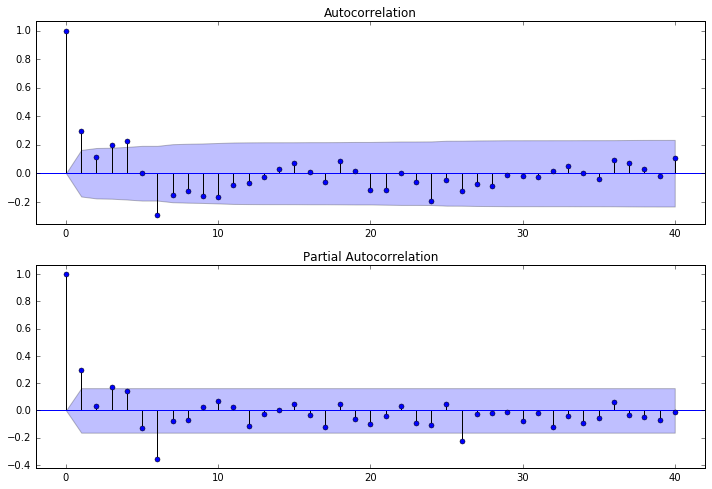

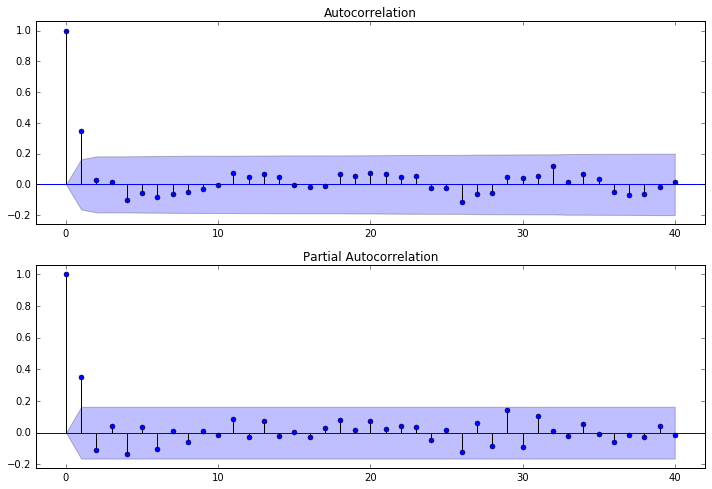

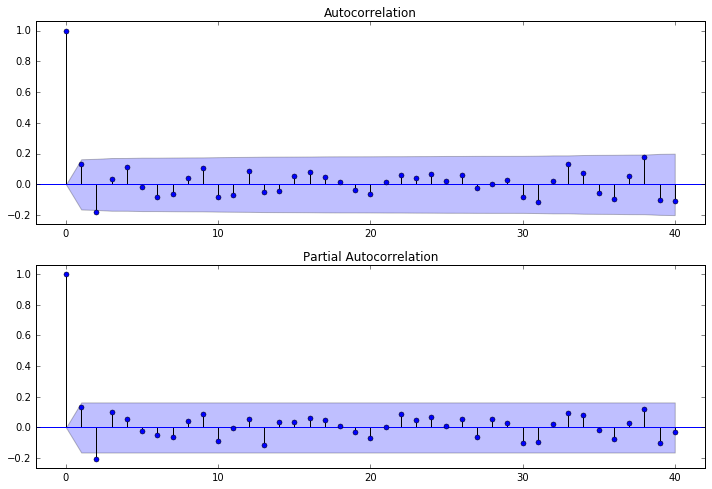

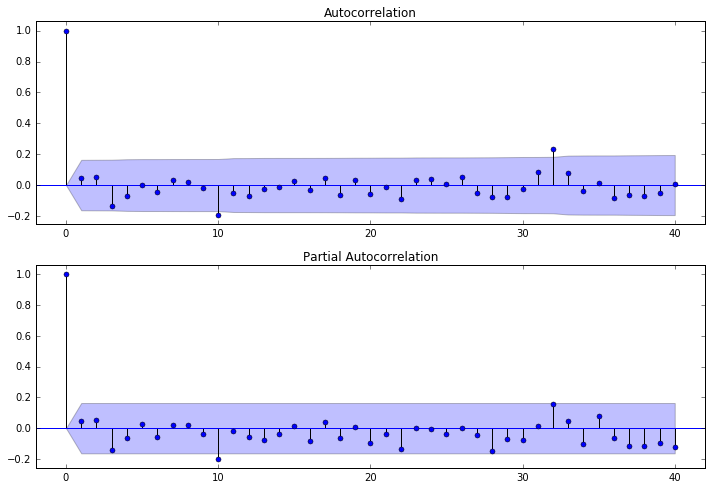

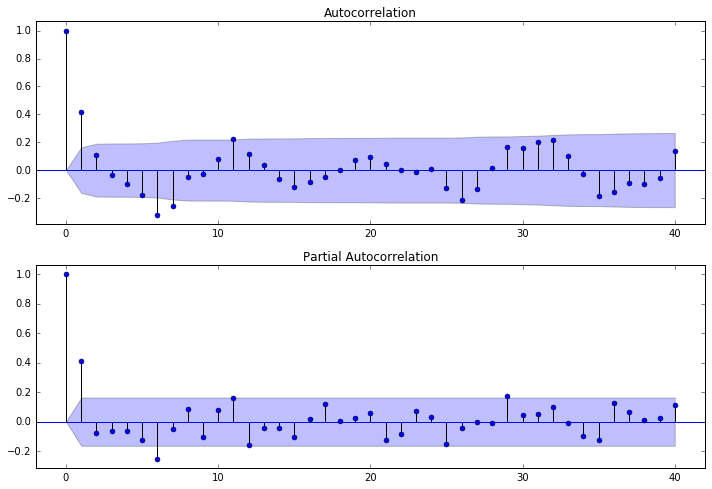

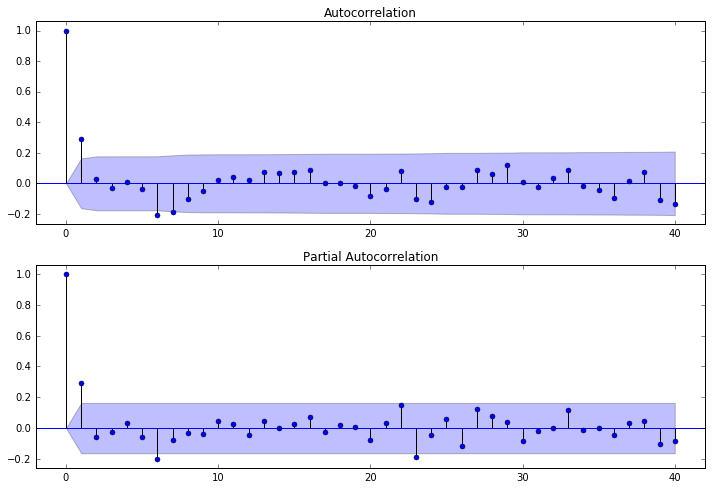

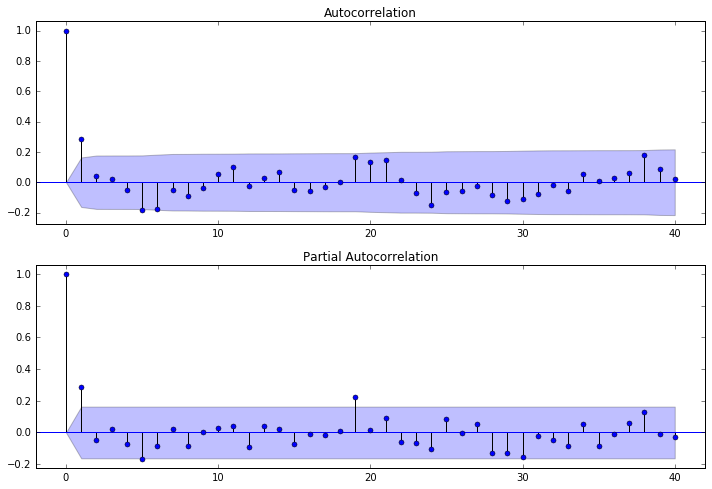

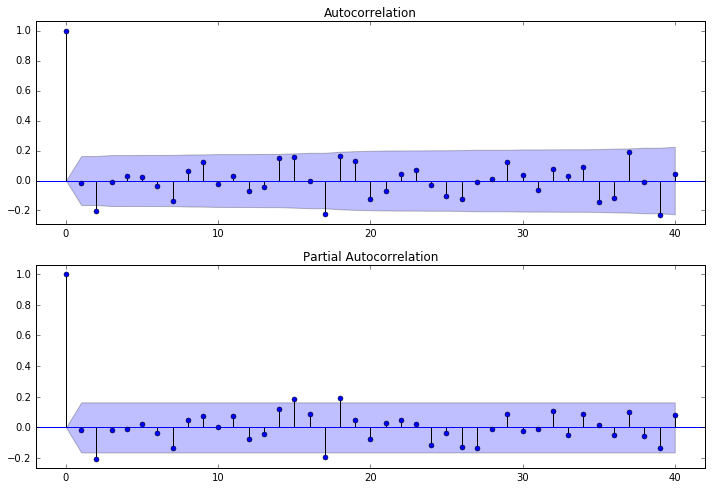

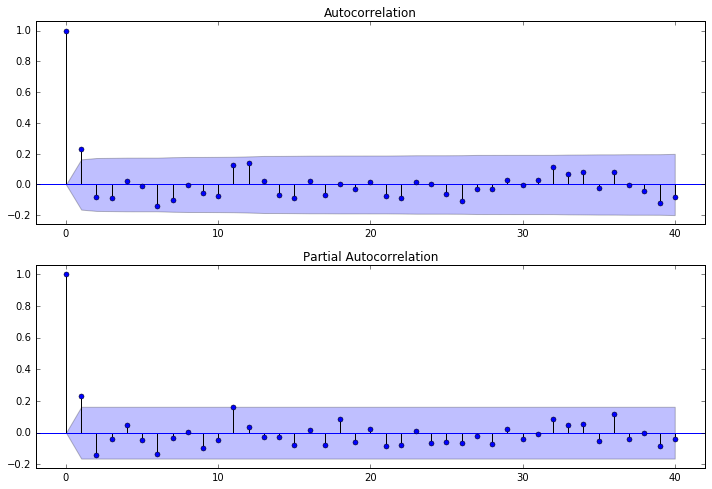

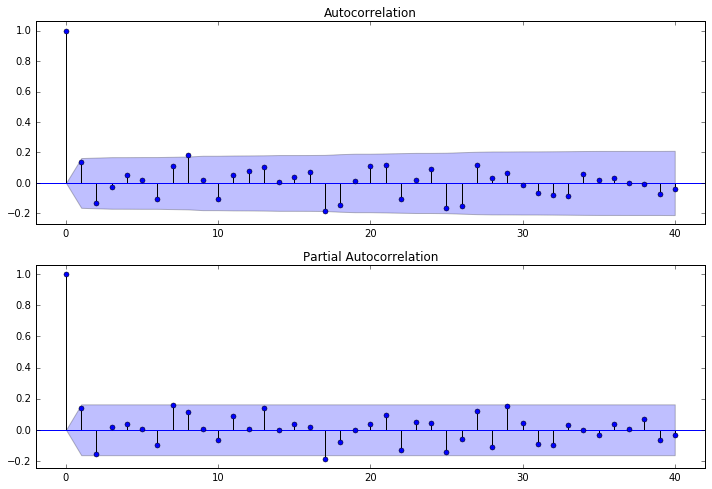

In [179]:
regr_coefs = []
k = 0

for ticker in sp500_tickers_lil:
    try:
        data = web.get_data_yahoo(ticker, start=st, end=en)
        k += 1
    except:
        print(ticker, "error")
        continue
        
    
    mdata = data.resample("M").pct_change().dropna()
    Y = mdata["Close"].values - np.mean(mdata["Close"].values)
    if jan:
        X = np.zeros([len(close),16]) # 1 constant + 12*mo + 1 2y + 1 3y + January
        X[0::12,-1] = 1
    else:
        X = np.zeros([len(close),15]) # 1 constant + 12*mo + 1 2y + 1 3y
    
    # constant
    X[:,0] = 1
    
    """
    # monthly lags
    for x in range(12):
        X[:,1+x] = np.roll(mdata["Close"].values,1+x)
        
    # 24m lags
    X[:,13] = np.roll(mdata["Close"].values,24)
    
    # 36m lags
    X[:,14] = np.roll(mdata["Close"].values,36)
    
    # truncate
    X = X[36:,:]
    Y = Y[36:]
    
    """
    """
    # monthly lags
    for x in range(12):
        X[:,1+x] = np.roll(mdata["Close"].values,1+x)
        
    # 24m lags
    X[:,13] = np.roll(mdata["Close"].values,24)
    
    # 36m lags
    X[:,14] = np.roll(mdata["Close"].values,36)
    
    # truncate
    X = X[36:,:]
    Y = Y[36:]
    
    """
    
    
    
    print("Ticker", ticker, "Regr. Start Date", mdata["Close"].index[36],"ndata",len(Y))
        
    result = sm.OLS(Y,X).fit()
    print(result.summary())
    regr_coefs.append(result.params)
    
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(Y, lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(Y, lags=40, ax=ax2)
    #plt.show()
    
#print("done")
avg_coefs = np.mean(np.array(regr_coefs),axis=0)
labels = ["const","1m","2m","3m","4m","5m","6m","7m","8m","9m","10m","11m","12m","24m","36m","Jan"]
for x in zip(labels, avg_coefs):
    print(x)

In [175]:
mdata

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2001-01-31,-0.075147,-0.071475,-0.086834,-0.084010,0.010082,-0.081401
2001-02-28,0.003664,0.002997,0.014708,0.010495,-0.154744,0.010495
2001-03-31,-0.024178,-0.027955,-0.026263,-0.027624,0.423454,-0.014937
2001-04-30,0.036546,0.039563,0.038377,0.040184,-0.280539,0.042425
2001-05-31,0.015382,0.013097,0.022107,0.018120,0.010954,0.018120
2001-06-30,0.009886,0.008626,0.005095,0.005805,0.151720,0.018437
2001-07-31,-0.049515,-0.050585,-0.051877,-0.051015,0.129868,-0.048988
2001-08-31,-0.011716,-0.008808,-0.006636,-0.007773,-0.455881,-0.007773
2001-09-30,-0.015537,-0.015105,-0.020411,-0.018252,2.214007,-0.006176


In [161]:
pd.DataFrame(X,Y)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.059849,1,0.098059,-0.037201,0.043218,0.024256,-0.072971,-0.064861,-0.106728,-0.009962,0.249862,0.141339,0.085143,0.290954,-0.273723,-0.101487,1
0.005379,1,0.061141,0.098059,-0.037201,0.043218,0.024256,-0.072971,-0.064861,-0.106728,-0.009962,0.249862,0.141339,0.085143,-0.383106,0.135610,0
-0.058031,1,0.006671,0.061141,0.098059,-0.037201,0.043218,0.024256,-0.072971,-0.064861,-0.106728,-0.009962,0.249862,0.141339,-0.180904,-0.080184,0
0.044549,1,-0.056739,0.006671,0.061141,0.098059,-0.037201,0.043218,0.024256,-0.072971,-0.064861,-0.106728,-0.009962,0.249862,0.239407,-0.041055,0
-0.013513,1,0.045841,-0.056739,0.006671,0.061141,0.098059,-0.037201,0.043218,0.024256,-0.072971,-0.064861,-0.106728,-0.009962,0.291006,-0.007567,0
-0.040815,1,-0.012221,0.045841,-0.056739,0.006671,0.061141,0.098059,-0.037201,0.043218,0.024256,-0.072971,-0.064861,-0.106728,-0.101762,-0.212684,0
0.024599,1,-0.039523,-0.012221,0.045841,-0.056739,0.006671,0.061141,0.098059,-0.037201,0.043218,0.024256,-0.072971,-0.064861,-0.124810,-0.245266,0
-0.255477,1,0.025891,-0.039523,-0.012221,0.045841,-0.056739,0.006671,0.061141,0.098059,-0.037201,0.043218,0.024256,-0.072971,0.422210,0.051363,0
-0.081050,1,-0.254185,0.025891,-0.039523,-0.012221,0.045841,-0.056739,0.006671,0.061141,0.098059,-0.037201,0.043218,0.024256,0.040167,0.341012,0
0.029485,1,-0.079758,-0.254185,0.025891,-0.039523,-0.012221,0.045841,-0.056739,0.006671,0.061141,0.098059,-0.037201,0.043218,-0.032342,-0.040729,0


In [150]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     3.418
Date:                Wed, 13 Apr 2016   Prob (F-statistic):           0.000249
Time:                        20:55:38   Log-Likelihood:                 108.63
No. Observations:                  85   AIC:                            -185.3
Df Residuals:                      69   BIC:                            -146.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0026      0.009      0.295      0.7